In [43]:
# Read data to table
# Per line is a dict
import json
import re
import numpy as np
p = re.compile('(?<!\\\\)\'')
ret = {}
def read_searching_log(output_data):
    datas = []
    with open(output_data, 'r') as f:
        lines = f.readlines()
        for line in lines:
            # Load data as dict
            data = p.sub('\"', line)
            param = json.loads(data)
            for k in param:
                if isinstance(param[k], list):
                    param[k] = param[k][0]
            # Add to datas
            datas.append(param)
    return datas
def print_res_to_table(res, sort_index="final_cost", number=10):
    import tabulate
    output_table = []
    #Add title
    if len(res) == 0:
        return []
    sort_values = []
    for row in res:
        output_table.append([])
        for k in row:
            v = row[k]
            if isinstance(v, np.ndarray) or isinstance(v, list):
                output_table[-1].append(v[0])
            else:
                if k == "ATE_T":
                    output_table[-1].append(f"{v:.3f}m")
                elif k == "ATE_rot":
                    output_table[-1].append(f"{v*57.3:.3f}")
                elif k == "final_cost":
                    output_table[-1].append(f"{v:.3f}")
                else:
                    output_table[-1].append(v)
            if k == sort_index:
                sort_values.append(v)
    output_table = np.array(output_table)
    sort_values = np.array(sort_values)
    output_table = output_table[sort_values.argsort()]
    row0 = []
    for key in res[0]:
        row0.append(key)
    output_table = output_table.tolist()
    output_table.insert(0, row0)
    output_table = output_table[:number]
    return tabulate.tabulate(output_table, tablefmt='html')

#Show the importance of the parameters using scatter plot
import matplotlib.pyplot as plt
def plot_param_vs_cost(ax, datas, param_name, cost_name="final_cost", max_cost=1e6):
    x = []
    y = []
    # Filter out the data with large cost
    datas = [data for data in datas if data[cost_name] < max_cost]
    for data in datas:
        x.append(data[param_name])
        y.append(data[cost_name])
    ax[0].hist2d(x, y, bins=1000)
    # Next we plot the param vs its min cost
    min_cost = {}
    for data in datas:
        if data[param_name] not in min_cost:
            min_cost[data[param_name]] = data[cost_name]
        else:
            min_cost[data[param_name]] = min(min_cost[data[param_name]], data[cost_name])
    x = []
    y = []
    for k in min_cost:
        x.append(k)
        y.append(min_cost[k])
    # Sorting by x
    x = np.array(x)
    y = np.array(y)
    order = x.argsort()
    x, y = x[order], y[order]
    ax[1].plot(x, y)
    for ax_ in ax:
        ax_.set_yscale('log')
        ax_.set_xscale('log')
        ax_.set_xlabel(param_name)
        ax_.set_ylabel(cost_name)
        ax_.grid(which='both')
    ax[1].set_ylabel(cost_name + " (min)")
plt.rc('figure', figsize=(20, 5))


max_steps,rho_frame_T,rho_frame_theta,eta_k,enable_rot_init,ATE_T,ATE_rot,final_cost
100,0.3913221322132213,1.5555885588558855,1.4545454545454546,True,1.150m,3.954,61.408
100,0.4993899389938994,1.983879387938794,1.6515151515151516,True,1.166m,3.988,61.575
100,0.32086908690869087,1.0815231523152316,1.9242424242424243,True,1.098m,4.282,61.803
100,0.7825952595259525,1.9178047804780478,1.803030303030303,True,1.198m,4.103,62.571


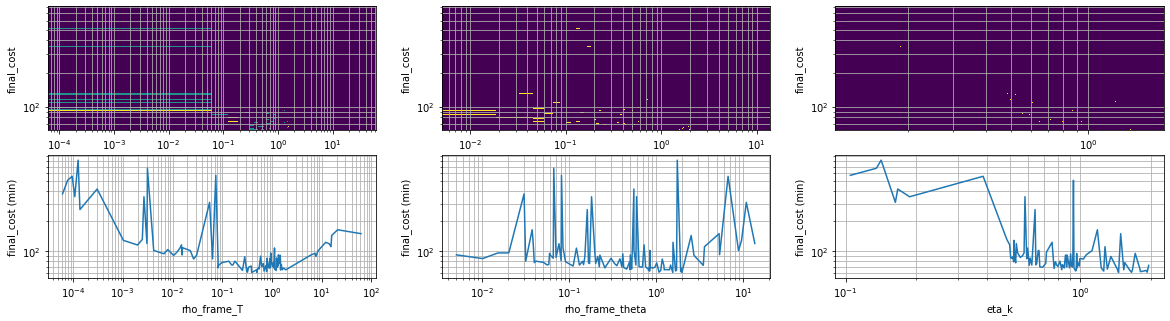

In [47]:
output_data = "/home/xuhao/data/d2slam/pgo/tum_corr_5/searching-output/search_result.txt"
params = ["rho_frame_T", "rho_frame_theta", "eta_k"]

datas = read_searching_log(output_data)
display(print_res_to_table(datas, number=5))
fig, ax = plt.subplots(2, len(params))
for i in range(len(params)):
    plot_param_vs_cost(ax[:,i], datas, params[i], max_cost=1000)
plt.show()